In [127]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Bidirectional, concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import yfinance as yf
import tensorflow as tf
from pandas_datareader.yahoo.daily import YahooDailyReader
from stockstats import StockDataFrame
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras import Input


# Define the list of stock tickers and the date range
stock_tickers = ['OXY']#, 'GOOGL', 'MSFT']  # Replace with your list of stock tickers
start_date = '2004-01-01'  # Replace with your desired start date
end_date = '2023-09-10'  # Replace with your desired end date
# end_date = datetime.today()

# Function to preprocess the data for LSTM model
def preprocess_data(stock_data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data['scaled_close'] = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))
    return stock_data


def preprocess_y(y):
    scaler = MinMaxScaler()
    reshaped_y = y.reshape(-1, 1)
    scaled_y = scaler.fit_transform(reshaped_y)
    # scaled_y = scaled.reshape(1, -1)
    print(scaled_y)
    return scaled_y

# Function to create sequences for training
def create_sequences(data, sequence_length, prediction_window):
    X = []
    y = []
    for i in range(len(data) - sequence_length - prediction_window + 1):
        X.append(data[i:i+sequence_length])
        future_price = data[i+sequence_length:i+sequence_length+prediction_window]
        current_price = data[i+sequence_length-1]
        price_change = future_price - current_price
        y.append(1 if np.any(price_change > 0) else 0)
    return np.array(X), np.array(y)

def create_time_steps(length):
    return list(range(-length, 0))

def single_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = 1#len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    # if true_future.any():
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
        label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

# def multivariate_data(dataset, target, start_index, end_index, history_size,
#                       target_size, step, single_step=False):
#     data = []
#     labels = []

#     start_index = start_index + history_size
#     if end_index is None:
#         end_index = len(dataset) - target_size

#     for i in range(start_index, end_index):
#         indices = range(i-history_size, i, step)
        
#         data.append(dataset[indices])

#         if single_step:
#             labels.append(target[i+target_size])
#         else:
#             labels.append(target[i:i+target_size])

#     return np.array(data), np.array(labels)

def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        if single_step:
            
            if target[i + target_size] > dataset[i][2]:
                labels.append(1)  # Price goes up
            else:
                labels.append(0)  # Price goes down
        else:
            if target[i:i + target_size] > dataset[i]:
                labels.append(1)  # Price goes up
            else:
                labels.append(0)  # Price goes down
    return np.array(data), np.array(labels)


def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

def multinew_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []   

    # start_index = start_index + history_size
    start_index = -history_size
    if end_index is None:
        end_index = len(dataset) 

    for i in range(start_index, end_index-target_size):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

    return np.array(data)

def prediction_plot(history, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(prediction[0])

    plt.plot(num_in, np.array(history), label='History')
    if prediction.any():
        # print(np.shape(np.arange(num_out)/STEP))
        # print(np.array(prediction)[0])
        plt.plot(np.arange(num_out)/STEP, np.array(prediction)[0], 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

[*********************100%%**********************]  1 of 1 completed


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

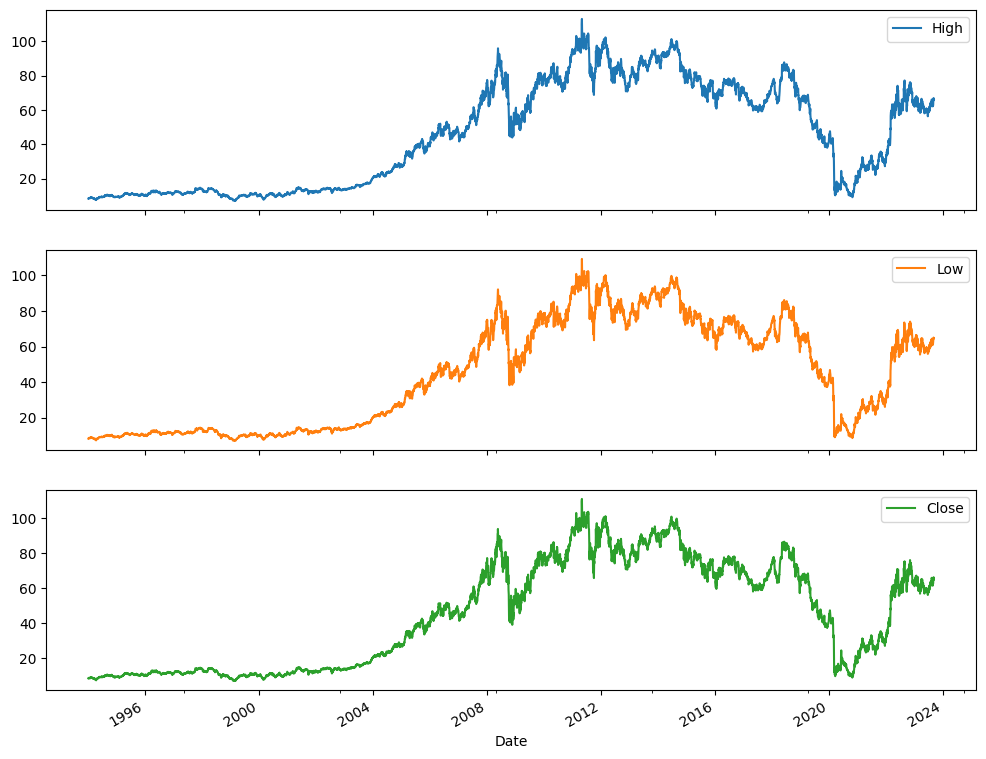

In [55]:
ticker = stock_tickers[0]

# df = YahooDailyReader(ticker, start='2018-01-01', end=datetime.now())
df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
# df = StockDataFrame.retype(df)
# df.head()

features_considered = ['High','Low', 'Close']
features = df[features_considered]
features.index = df.index
features.head()

features.plot(subplots=True,figsize=[12,10])

In [56]:
# Assuming your dataframe is called 'df' with columns 'column1', 'column2', 'column3'
columns_to_normalize = ['High', 'Low', 'Close']

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the selected columns
scaler.fit(features[columns_to_normalize])

# Transform the selected columns using the scaler
features[columns_to_normalize] = scaler.transform(features[columns_to_normalize])

dataset = features.values

dataset

/var/folders/ym/67x0srsx2ln9vy4qtlvtdv500000gn/T/ipykernel_38947/1943095077.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[columns_to_normalize] = scaler.transform(features[columns_to_normalize])


array([[0.01188292, 0.01170768, 0.01268859],
       [0.01358049, 0.01287846, 0.01211185],
       [0.01358049, 0.01287846, 0.01384211],
       ...,
       [0.56108733, 0.56656834, 0.56351485],
       [0.55258233, 0.56148478, 0.55388282],
       [0.55399984, 0.56519969, 0.56072155]])

In [134]:
# Hyperparameters
BATCH_SIZE = 8
BUFFER_SIZE = 1000
TRAIN_SPLIT = int(df.shape[0] * 0.8)


past_history = 20
future_target = 5
STEP = 1


x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP, True)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, True)

print(x_train_multi.shape,y_train_multi.shape)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

# list(train_data_multi.as_numpy_iterator())[0]

(3948, 20, 3) (3948,)


In [135]:
# LSTM Parameters
EVALUATION_INTERVAL = 30#len(x_train_multi)//batch_size//2 #15
VALIDATION_INTERVAL = 30#len(x_val_multi)//batch_size//2
EPOCHS = 50
PATIENCE = 5

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)

# Input layer
input_layer = Input(shape=x_train_multi.shape[-2:])

# LSTM branch for opening price prediction 
# lstm_branch_1 = LSTM(64)(input_layer)
# highest_price_output = Dense(1, activation='linear', name='highest_price')(lstm_branch_1)

# # LSTM branch for lowest price prediction
# lstm_branch_2 = LSTM(64)(input_layer) 
# lowest_price_input = concatenate([highest_price_output, lstm_branch_2])
# lowest_price_output = Dense(1, activation='linear', name='lowest_price')(lowest_price_input)

# # LSTM branch for highest price prediction
# lstm_branch_3 = LSTM(64)(input_layer)
# close_price_input = concatenate([highest_price_output, lowest_price_output, lstm_branch_3])
# close_price_output = Dense(5, activation='linear', name='close_price')(close_price_input)



# LSTM branch for opening price prediction 
lstm_branch_1 = LSTM(256)(input_layer)
lstm_branch_1_dropout = Dropout(0.3)(lstm_branch_1)
highest_price_output = Dense(1, activation='sigmoid', name='highest_price')(lstm_branch_1_dropout)

# LSTM branch for lowest price prediction
lstm_branch_2 = LSTM(128)(input_layer) 
lstm_branch_2_dropout = Dropout(0.3)(lstm_branch_2)
lowest_price_input = concatenate([highest_price_output, lstm_branch_2_dropout])
lowest_price_output = Dense(1, activation='sigmoid', name='lowest_price')(lowest_price_input)

# LSTM branch for highest price prediction
lstm_branch_3 = LSTM(64)(input_layer)
lstm_branch_3_dropout = Dropout(0.3)(lstm_branch_3)
close_price_input = concatenate([highest_price_output, lowest_price_output, lstm_branch_3_dropout])
close_price_output = Dense(1, activation='sigmoid', name='close_price')(close_price_input)

# Define the model
model = Model(inputs=input_layer, outputs=[close_price_output])

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),loss='binary_crossentropy', metrics='binary_accuracy')
print(model.summary())

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 20, 3)]              0         []                            
                                                                                                  
 lstm_52 (LSTM)              (None, 256)                  266240    ['input_19[0][0]']            
                                                                                                  
 dropout_18 (Dropout)        (None, 256)                  0         ['lstm_52[0][0]']             
                                                                                                  
 lstm_53 (LSTM)              (None, 128)                  67584     ['input_19[0][0]']            
                                                                                           

In [136]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5,  restore_best_weights=True)
multi_step_history = model.fit(train_data_multi,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data_multi,
                                validation_steps=VALIDATION_INTERVAL,
                                callbacks=[early_stopping])

Epoch 1/50


2023-09-27 01:03:26.245997: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are 


30/30 [==============================] - ETA: 0s - loss: 0.6965 - binary_accuracy: 0.5667

2023-09-27 01:04:01.648332: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are 


30/30 [==============================] - 45s 389ms/step - loss: 0.6965 - binary_accuracy: 0.5667 - val_loss: 0.7000 - val_binary_accuracy: 0.4125
Epoch 2/50
30/30 [==============================] - 8s 264ms/step - loss: 0.6878 - binary_accuracy: 0.5750 - val_loss: 0.7105 - val_binary_accuracy: 0.4125
Epoch 3/50
30/30 [==============================] - 8s 276ms/step - loss: 0.6917 - binary_accuracy: 0.5792 - val_loss: 0.7184 - val_binary_accuracy: 0.4125
Epoch 4/50
30/30 [==============================] - 7s 247ms/step - loss: 0.6690 - binary_accuracy: 0.6333 - val_loss: 0.7297 - val_binary_accuracy: 0.4125
Epoch 5/50
30/30 [==============================] - 4s 117ms/step - loss: 0.6905 - binary_accuracy: 0.5625 - val_loss: 0.7207 - val_binary_accuracy: 0.4125
Epoch 6/50
30/30 [==============================] - 3s 104ms/step - loss: 0.6832 - binary_accuracy: 0.5833 - val_loss: 0.7104 - val_binary_accuracy: 0.4125


2023-09-27 01:04:41.089391: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Axes: title={'center': 'Accuracy'}>

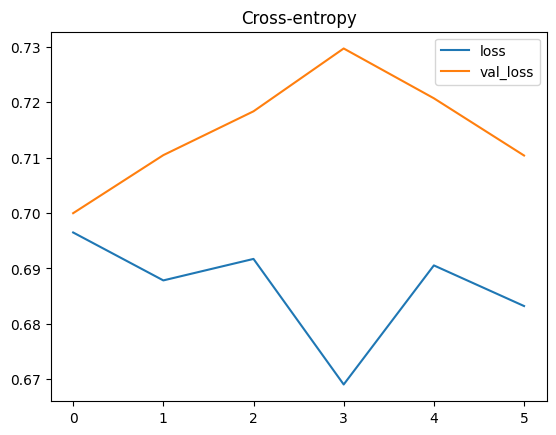

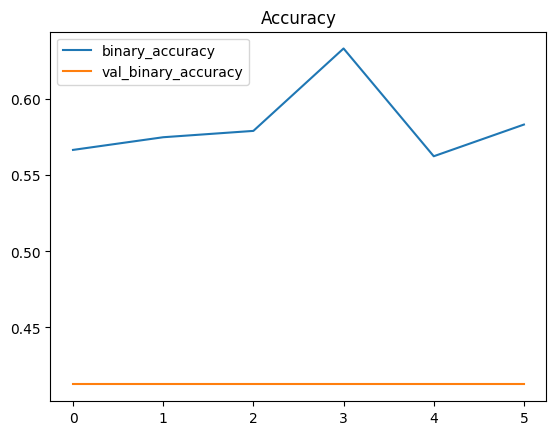

In [137]:
history_df = pd.DataFrame(multi_step_history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

2023-09-27 01:06:33.346198: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are 
2023-09-27 01:06:33.530199: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1/1 [==============================] - 4s 4s/step


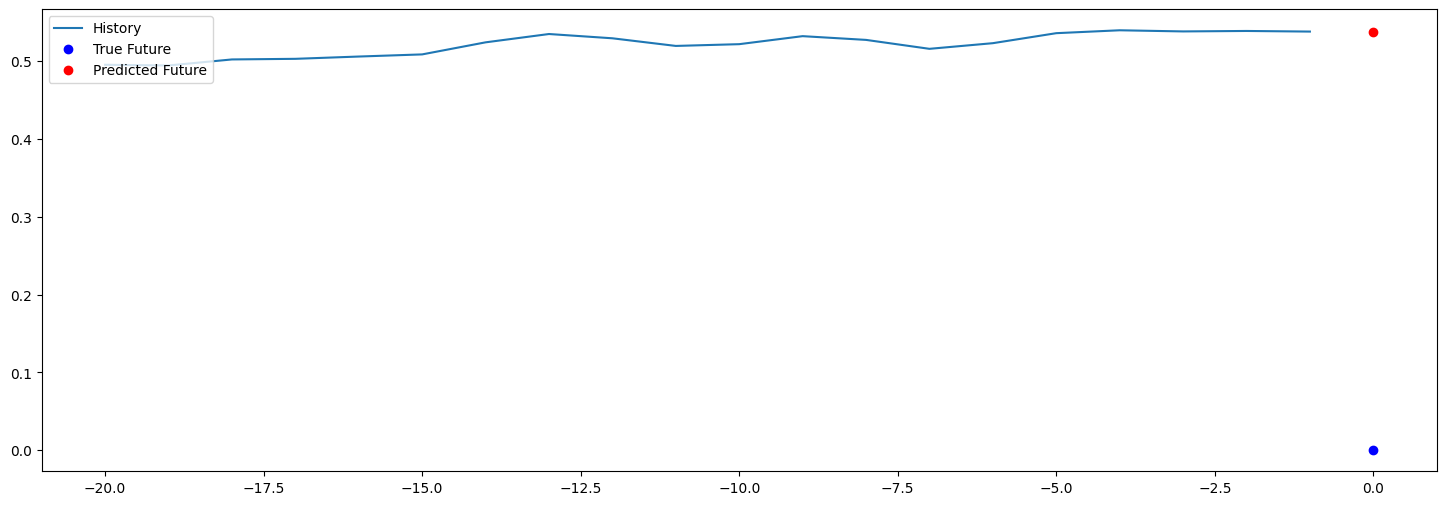

1/1 [==============================] - 0s 50ms/step
[[0.5369539 ]
 [0.53714454]
 [0.5372509 ]
 [0.53724635]
 [0.537159  ]
 [0.5370822 ]
 [0.5370954 ]
 [0.5370811 ]]
1/1 [==============================] - 0s 50ms/step


2023-09-27 01:06:38.207535: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false

2023-09-27 01:06:38.357596: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



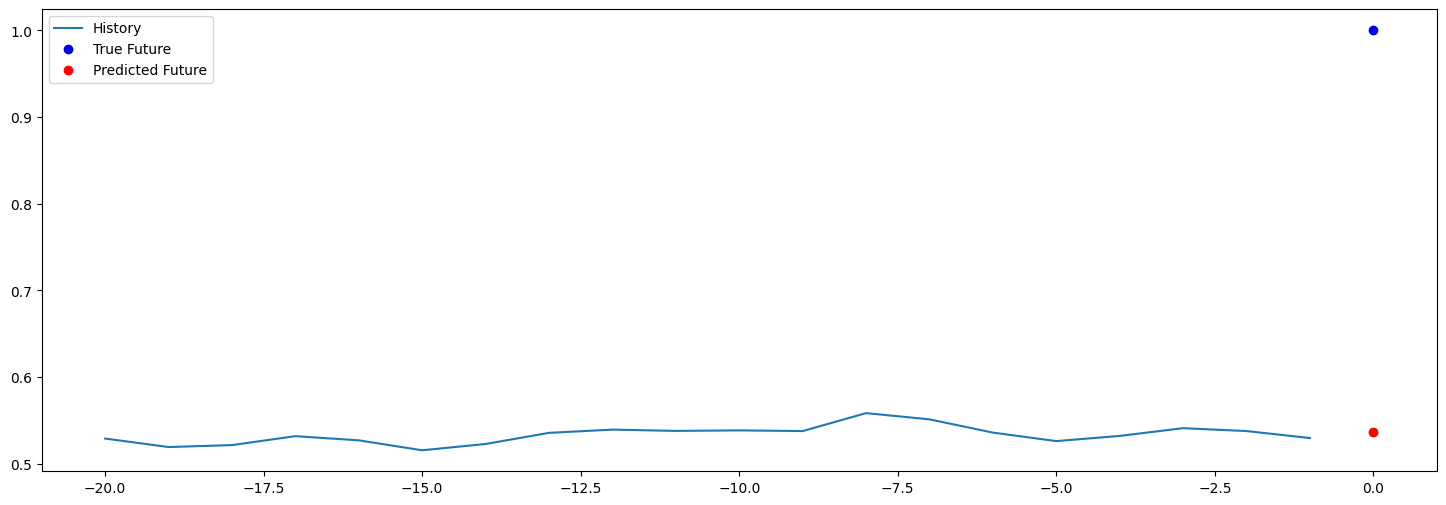

1/1 [==============================] - 0s 51ms/step
[[0.53701067]
 [0.5368829 ]
 [0.5367088 ]
 [0.53660154]
 [0.53654313]
 [0.5365175 ]
 [0.53651446]
 [0.5365432 ]]
1/1 [==============================] - ETA: 0s

2023-09-27 01:06:39.383525: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false

2023-09-27 01:06:39.539811: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1/1 [==============================] - 0s 48ms/step


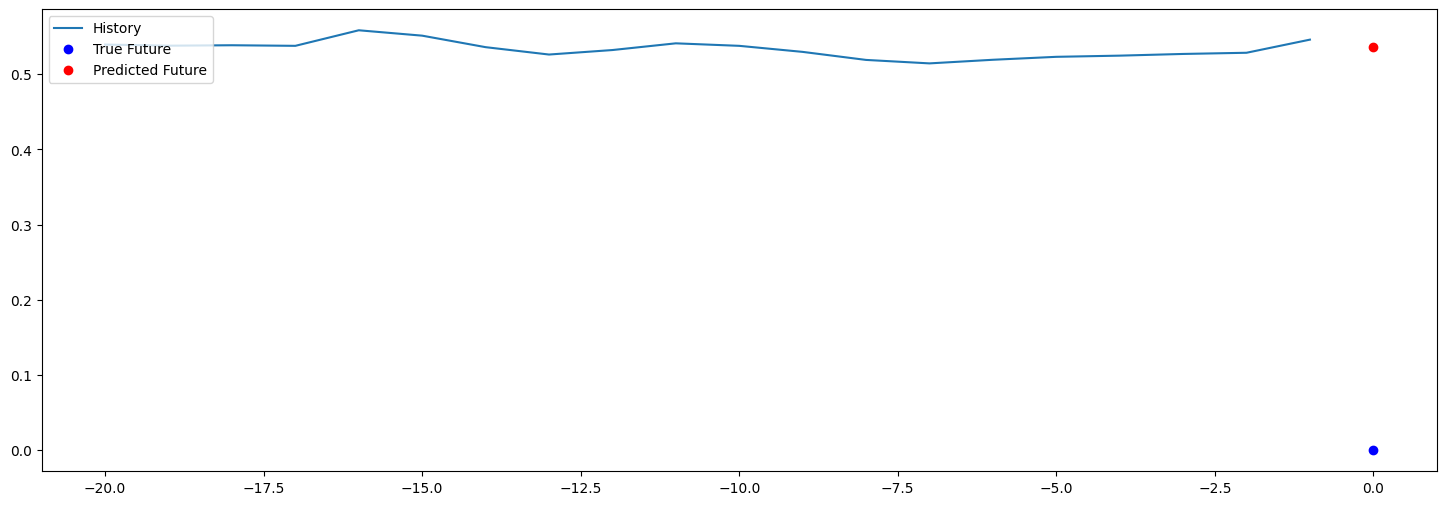

1/1 [==============================] - 0s 80ms/step
[[0.5367019 ]
 [0.53697205]
 [0.5371712 ]
 [0.5372586 ]]


2023-09-27 01:06:40.538762: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



In [138]:
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, True)

x_val_multi = x_val_multi[-20:]
y_val_multi = y_val_multi[-20:]

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))

val_data_multi = val_data_multi.batch(BATCH_SIZE)#.repeat()

for x, y in val_data_multi.take(5):
    single_step_plot(x[0], y[0], model.predict(x)[0])
    
    print(model.predict(x))


In [139]:
end_date = '2023-09-17'

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

features_considered = ['Close','High','Low']
features = df[features_considered]
features.index = df.index


# Assuming your dataframe is called 'df' with columns 'column1', 'column2', 'column3'
columns_to_normalize = ['Close', 'High', 'Low']

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the selected columns
scaler.fit(features[columns_to_normalize])

# Transform the selected columns using the scaler
features[columns_to_normalize] = scaler.transform(features[columns_to_normalize])

dataset = features.values



x_new_multi = multinew_data(dataset, dataset[:, 2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

x_new_multi = x_new_multi[-20:]

predictions_0 = model.predict(x_new_multi[0:1])
predictions_1 = model.predict(x_new_multi[-1:])#[0]
    

predictions_0, predictions_1
# np.shape(x_new_multi)

model.predict(x_new_multi)

[*********************100%%**********************]  1 of 1 completed


/var/folders/ym/67x0srsx2ln9vy4qtlvtdv500000gn/T/ipykernel_38947/1279074575.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[columns_to_normalize] = scaler.transform(features[columns_to_normalize])
2023-09-27 01:06:41.582551: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1/1 [==============================] - 0s 96ms/step


2023-09-27 01:06:44.830977: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1/1 [==============================] - 0s 49ms/step


2023-09-27 01:06:45.069529: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



array([[0.5369539 ],
       [0.53714454],
       [0.5372509 ],
       [0.53724635],
       [0.537159  ],
       [0.5370822 ],
       [0.5370954 ],
       [0.5370811 ],
       [0.53701067],
       [0.5368829 ],
       [0.5367088 ],
       [0.53660154],
       [0.53654313],
       [0.5365175 ],
       [0.53651446],
       [0.5365432 ],
       [0.5367019 ],
       [0.53697205],
       [0.5371712 ],
       [0.5372586 ]], dtype=float32)

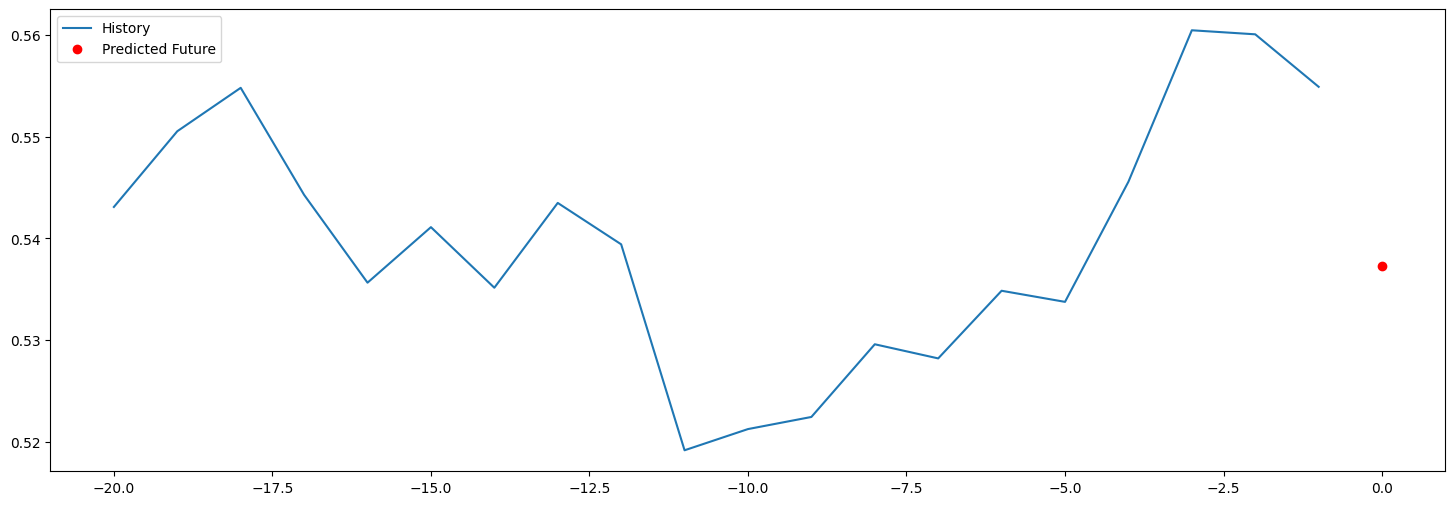

In [140]:
# New Predictions
# prediction_plot(x_new_multi[0][:,0], predictions_0)
prediction_plot(x_new_multi[-1][:,2], predictions_1)